<h2><center> Welcome to the Ernst & Young Carbon Prediction Hackathon</h2></center>
<figure>
<!-- <center><img src ="https://drive.google.com/uc?export=view&id=1hSOAfRhJ_jo-MZAjq81VYJu5bZNL7EjD" width = "800" height = '500'/> -->

*About the problem*
> The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.

*Objective of this challenge*
> The objective of this challenge is to create machine learning or a deep learning model using open-source CO2 emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.

These solutions will enable EY, governments, and other actors to estimate carbon emission levels across Africa, even in places where on-the-ground monitoring is not possible.



## Table of contents:

1. [Installing and importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Outliers](#Outliers)
5. [Geo Visualisation - EDA](#Geo)
5. [Missing values and duplicates](#Missing)
6. [Date features EDA](#Dates)
7. [Correlations - EDA](#Correlations)
9. [Timeseries visualization - EDA](#Timeseries)
10. [Feature engineering](#Engineering)
11. [Modelling](#Modelling)
12. [Making predictions of the test set and creating a submission file](#Predictions)

<a name="Libraries"></a>
## 1. Installing and importing libraries


In [1]:
%%capture
# Install relevant libraries
!pip install geopandas folium 

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

<a name="Data"></a>
## 2. Loading and previewing data

In [4]:

DATA_PATH = ''
# Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'Train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'Test.csv'))
samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'SampleSubmission.csv'))

# Preview train dataset
train.head()

In [5]:
# Preview test dataset
test.head()

In [ ]:
test.tail(20)

In [6]:

# Preview sample submission file
samplesubmission.head()

In [7]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((74005, 76), (28085, 75), (28085, 2))

In [8]:
# Train to test sets ratio
(test.shape[0]) / (train.shape[0] + test.shape[0])

0.2751004016064257

<a name="Statistics"></a>
## 3. Statistical summaries

In [9]:
# Train statistical summary
train.describe(include = 'all')

In [ ]:
# train.info()

From the above statistical summary, we can deduce some of the following insights:
 - The train data provided ranges from year *2019 to 2022*
 - Minimum recorded CO2 emissions is *0.04806* and a maximum of *1181701.2*
 - Week of the year starts from 1 to 52
 - The latitude and longitudes ranges show that the regions are mostly within South Africa 

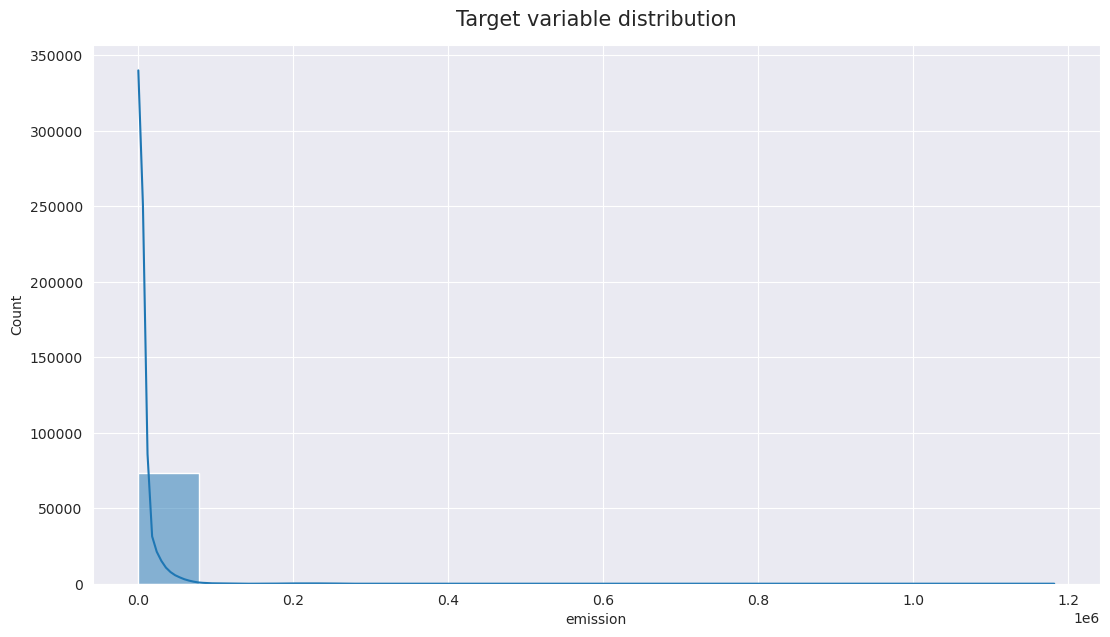

None

17.038027449698163

In [10]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())

The target variable is skewed to the right with a a degree of ~17.

Some of the techniques used to handle skewness include:
- Log transform
- Box-cox transform
- Square root transform
- *etc*

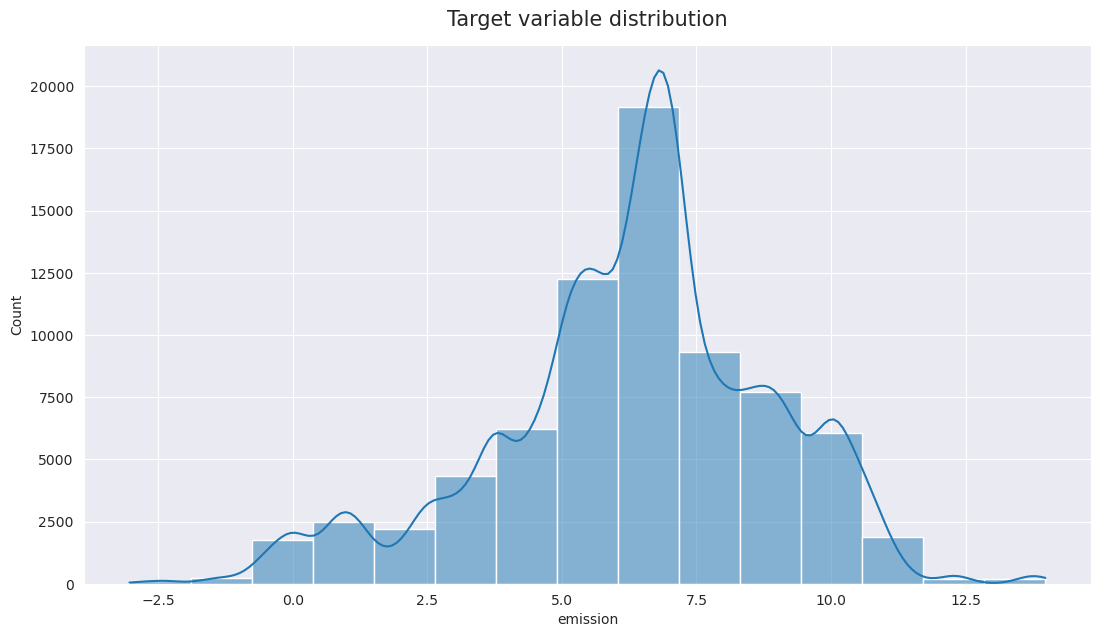

None

-0.4685478820791871

In [ ]:
# Log transform
tm=np.log(train.emission)
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(tm, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), tm.skew())


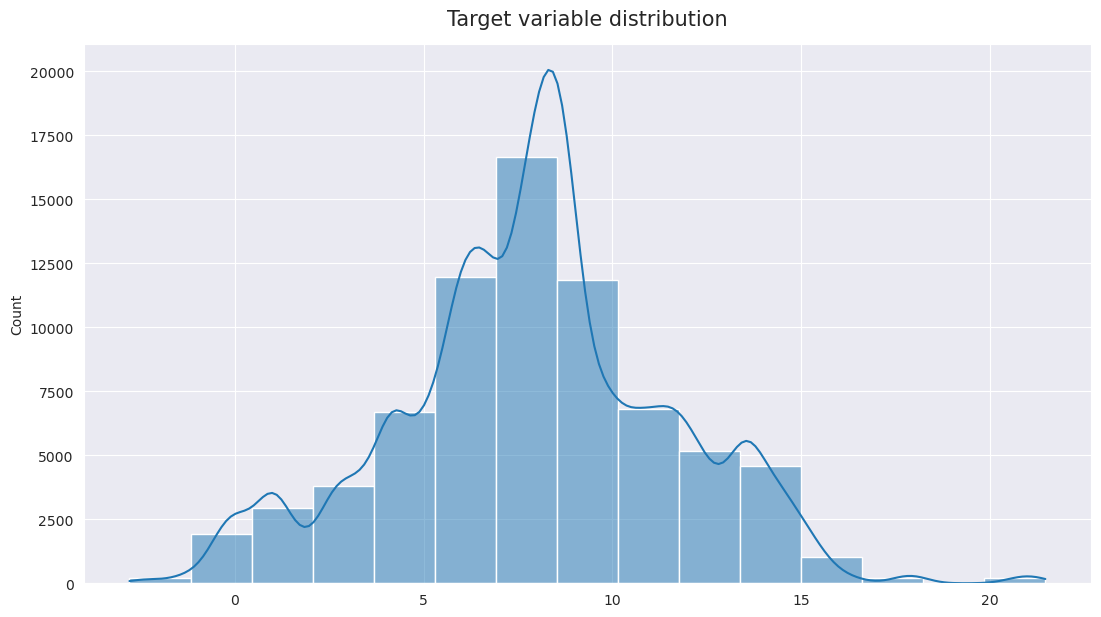

None

0.057450389972568995

In [ ]:
# Box cox
from scipy import stats
tmb,opt=stats.boxcox(train.emission)
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(tmb, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), opt)

Normalizing the right-skewed data using power transformation

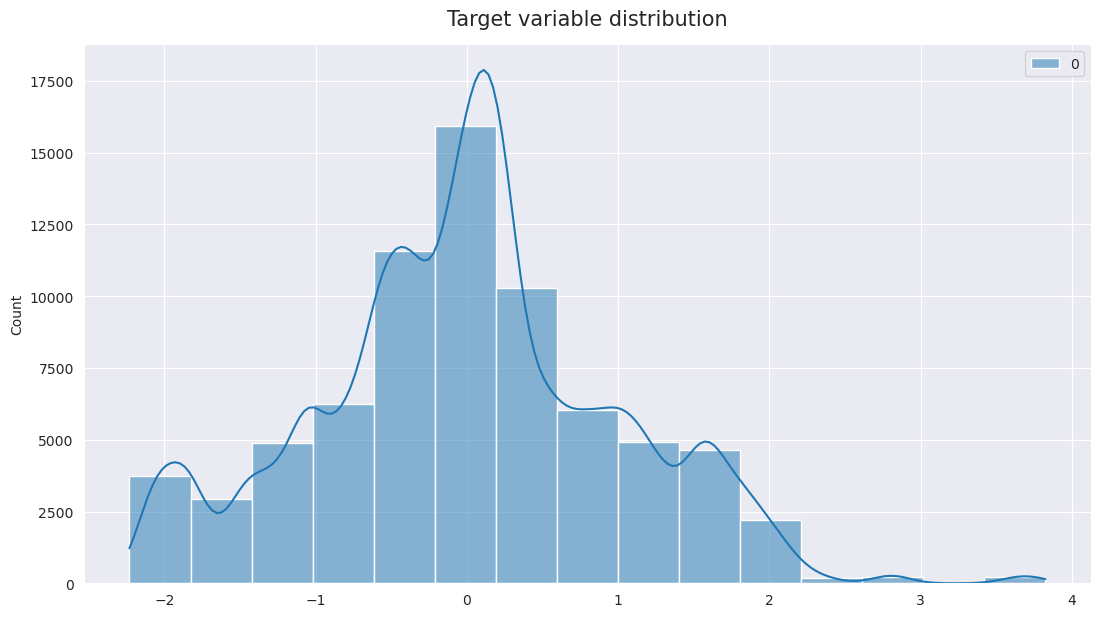

None

0.057450389972568995

In [ ]:
from sklearn.preprocessing import StandardScaler
min_val = min(train.emission)
min_val
shifted_data = np.array(train.emission) - min_val + 1
transformed_data = np.power(shifted_data, 1/17)
normalized = StandardScaler().fit_transform(transformed_data.reshape(-1, 1))

sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(normalized, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), opt)



In [ ]:
# columns=train.columns
# col1=train['ID_LAT_LON_YEAR_WEEK']
# # train=train.drop('ID_LAT_LON_YEAR_WEEK',axis=1)
# numeric_df = train.select_dtypes(include=['float64', 'int64'])
# scaler=StandardScaler()
# scaler.fit(numeric_df)
# scaled_data=scaler.transform(numeric_df)

# scaled_data=np.log(scaled_data)

# # type(columns)
# # columns=columns.delete(columns.get_loc('ID_LAT_LON_YEAR_WEEK'))
# # columns

Boxplot of the above normalized data

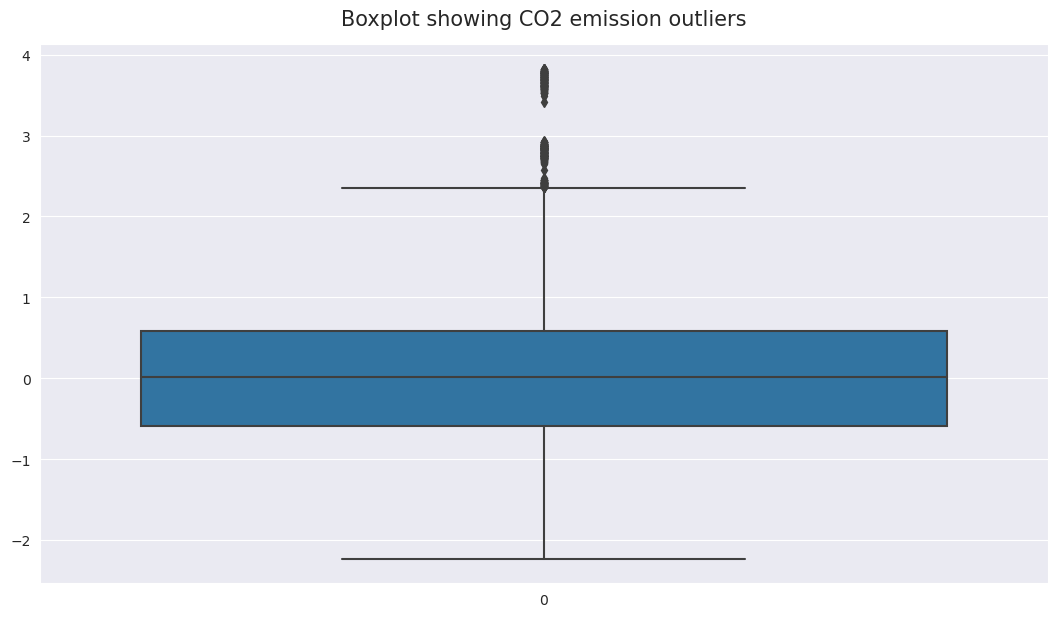

In [ ]:
# Plotting boxplot for the CO2 emissions
# Using log transform
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
# sns.boxplot(train.emission)
sns.boxplot(normalized)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
plt.show()

<a name="Outliers"></a>
## 4. Outliers


In [ ]:
# # Log transformation 
# train.emission = np.log1p(train.emission)
# test.emission = np.log1p(test.emission)
# train.emission.describe()

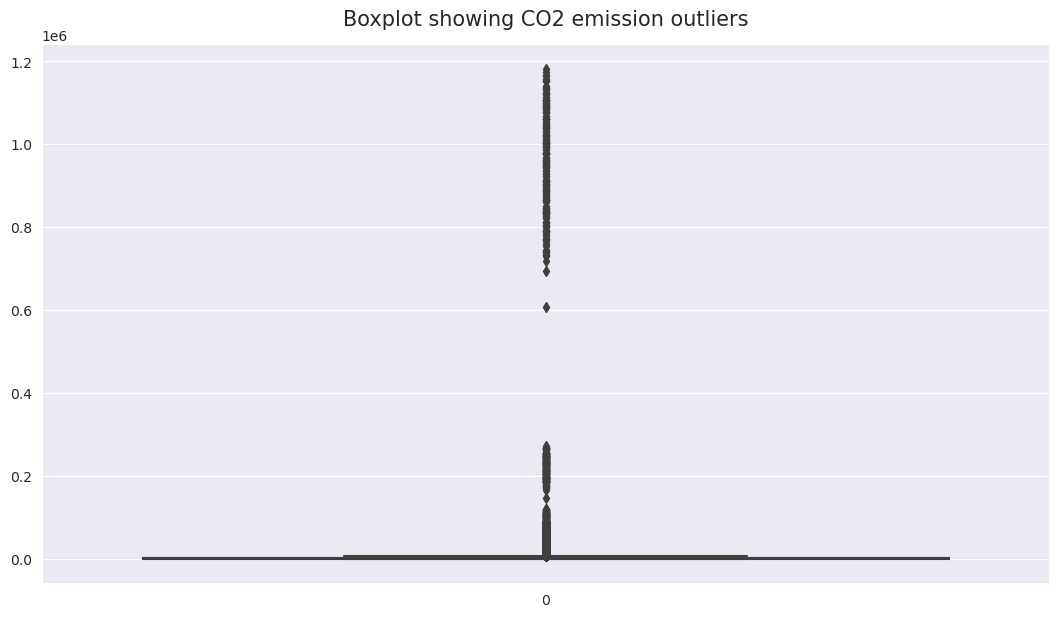

In [11]:
# Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.emission)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
plt.show()

In [ ]:
# # columns=columns.delete(columns.get_loc('ID_LAT_LON_YEAR_WEEK'))
# # columns=train.drop('ID_LAT_LON_YEAR_WEEK',axis=1)
# # print(columns)

# train=pd.DataFrame(scaled_data,columns=columns)


# # train = pd.concat([col1, train], axis=1)

# scaled_data.shape

In [ ]:
# # Plotting boxplot for the CO2 emissions
# # Using log transform
# sns.set_style('darkgrid')
# plt.figure(figsize = (13, 7))
# # sns.boxplot(train.emission)
# sns.boxplot(tm)
# plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)  
# plt.show()

In [ ]:
# # mean_em=np.mean(train)
# # Z_score=(train.emission -mean_em) /np.std(train)
# # no_outlier=np.mean(train<Z_score)
# # train[train>Z_score]=no_outlier

# # numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# train=train.select_dtypes(include=numerics)

# meant=np.mean(train)
# std=np.std(train)
# # # x.head()
# z_sc=[(x-meant)/std for x in train]
# outlier=[x[i] for i,dt in enumerate(z_sc) if abs(dt)>2.5]

# for x in train:
#         if type !=object:
#             continue
#         if type=='str':
#             continue
# #         std=np.std(x)
#         z_sc=(x+meant)/std


Outliers are those data points which differ significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...
 

<a name="Geo"></a>
## 5. Geo Visualisation - EDA

In [12]:
# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
test_coords = test.drop_duplicates(subset = ['latitude', 'longitude'])
train_coords['set_type'], test_coords['set_type'] = 'train', 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index = True)
# Create point geometries

geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(
    all_data[["latitude", "longitude", "set_type"]], geometry=geometry
)

# Preview the geopandas df
geo_df.head()

In [13]:
# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type set
    if geo_df.set_type[i] == "train":
        type_color = "green"
    elif geo_df.set_type[i] == "test":
        type_color = "orange"

    # Place the markers 
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            popup= 
            "Set: " + str(geo_df.set_type[i]) + "<br>"
            "Coordinates: " + str([round(x, 2) for x in geo_df_list[i]]),
            color =  type_color),
        )
    i = i + 1
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

Make this Notebook Trusted to load map: File -> Trust Notebook <iframe srcdoc="<!DOCTYPE html>
<html>
<head>
 
 <meta http-equiv="content-type" content="text/html; charset=UTF-8" />
 
 <script>
 L_NO_TOUCH = false;
 L_DISABLE_3D = false;
 </script>
 
 <style>html, body {width: 100%;height: 100%;margin: 0;padding: 0;}</style>
 <style>#map {position:absolute;top:0;bottom:0;right:0;left:0;}</style>
 <script src="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js"></script>
 <script src="https://code.jquery.com/jquery-1.12.4.min.js"></script>
 <script src="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js"></script>
 <script src="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js"></script>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://netdna.bootstrapcdn.com/bootstrap/3.0.0/css/bootstrap.min.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/@fortawesome/fontawesome-free@6.2.0/css/all.min.css"/>
 <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.css"/>
 <link rel="stylesheet" href="https://cdn.jsdelivr.net/gh/python-visualization/folium/folium/templates/leaflet.awesome.rotate.min.css"/>
 
 <meta name="viewport" content="width=device-width,
 initial-scale=1.0, maximum-scale=1.0, user-scalable=no" />
 <style>
 #map_ece5ea6fcd2d5beed652a4da189b9452 {
 position: relative;
 width: 100.0%;
 height: 100.0%;
 left: 0.0%;
 top: 0.0%;
 }
 .leaflet-container { font-size: 1rem; }
 </style>
 
</head>
<body>
 
 
 <div class="folium-map" id="map_ece5ea6fcd2d5beed652a4da189b9452" ></div>
 
</body>
<script>
 
 
 var map_ece5ea6fcd2d5beed652a4da189b9452 = L.map(
 "map_ece5ea6fcd2d5beed652a4da189b9452",
 {
 center: [0, 0],
 crs: L.CRS.EPSG3857,
 zoom: 1,
 zoomControl: true,
 preferCanvas: true,
 }
 );

 

 
 
 var tile_layer_04dd15f71bc19d4017ceb1b19ad09f85 = L.tileLayer(
 "https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
 {"attribution": "Data by \u0026copy; \u003ca target=\"_blank\" href=\"http://openstreetmap.org\"\u003eOpenStreetMap\u003c/a\u003e, under \u003ca target=\"_blank\" href=\"http://www.openstreetmap.org/copyright\"\u003eODbL\u003c/a\u003e.", "detectRetina": false, "maxNativeZoom": 18, "maxZoom": 18, "minZoom": 0, "noWrap": false, "opacity": 1, "subdomains": "abc", "tms": false}
 ).addTo(map_ece5ea6fcd2d5beed652a4da189b9452);
 
 
 var circle_marker_6ae5cfe20264a62baf8045a826fb5385 = L.circleMarker(
 [-23.72999999999353, 28.769999999988148],
 {"bubblingMouseEvents": true, "color": "green", "dashArray": null, "dashOffset": null, "fill": false, "fillColor": "green", "fillOpacity": 0.2, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 1, "stroke": true, "weight": 4}
 ).addTo(map_ece5ea6fcd2d5beed652a4da189b9452);
 
 
 var popup_c59af09ab80410a688b5e5a27a0b26bf = L.popup({"maxWidth": "100%"});

 
 
 var html_af4527c517fedb701cada5af060988b5 = $(`<div id="html_af4527c517fedb701cada5af060988b5" style="width: 100.0%; height: 100.0%;">Set: train<br>Coordinates: [-23.73, 28.77]</div>`)[0];
 popup_c59af09ab80410a688b5e5a27a0b26bf.setContent(html_af4527c517fedb701cada5af060988b5);
 
 

 circle_marker_6ae5cfe20264a62baf8045a826fb5385.bindPopup(popup_c59af09ab80410a688b5e5a27a0b26bf)
 ;

 
 
 
 var circle_marker_86b34676d72a74e330ae38f1b758335a = L.circleMarker(
 [-23.729999999993534, 28.769999999988148],
 {"bubblingMouseEvents": true, "color": "green", "dashArray": null, "dashOffset": null, "fill": false, "fillColor": "green", "fillOpacity": 0.2, "fillRule": "evenodd", "lineCap": "round", "lineJoin": "round", "opacity": 1.0, "radius": 1, "stroke": true, "weight": 4}
 ).addTo(map_ece5ea6fcd2d5beed652a4da189b9452);
 
 
 var popup_286852d86585cabab1b88d2be

<a name="Missing"></a>
## 6. Missing values and duplicates

In [14]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 


(True, True)

In [ ]:
# train.dropna()
# missing_values = train.isnull().mean() * 100
# features_to_drop = missing_values[missing_values > 4].index
# train.drop(features_to_drop,axis=0,inplace=True)
# train=[tr in train for if tr.isnull() tr.fillna(np.mean(tr) ]
# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# train = train.select_dtypes(include=numerics)



# for tr in train:

    
#     if type !=object:
#         continue
#     if type=='str':
#             continue
#     if tr.isnan()==True:
# #         meant=np.mean(tr)
#         train[tr]=train[tr].fillna(value=tr.mean())
# # print(train.isnull())

In [ ]:
missing_values = train.isnull().mean() * 100
features_to_drop = missing_values[missing_values > 92].index
train.drop(features_to_drop,inplace=True,axis=1)

train = train.fillna(train.mean())
test = test.fillna(test.mean())

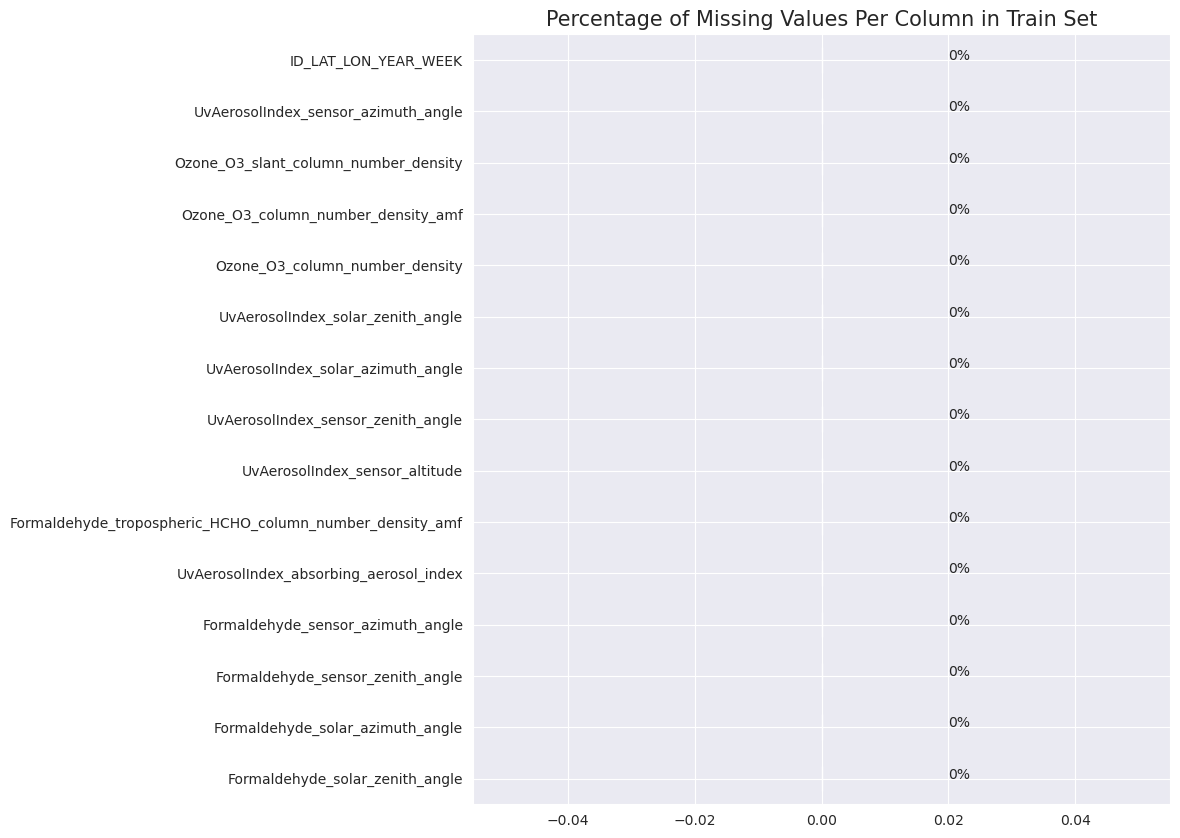

In [15]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:15][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

In [ ]:
# train.columns

In [ ]:
# train.fillna(value=train['NitrogenDioxide_NO2_column_number_density'].mean())
# train.mean()
# na_list=[x for x in train if ]
# train.dropna(axis=1)
# train.drop(train['UvAerosolIndex_sensor_zenith_angle,Uv'])
# dr=train.drop(axis=1)
# print(dr)
# train.drop(columns=['UvAerosolIndex_sensor_zenith_angle','UvAerosolIndex_solar_azimuth_angle'], inplace=True)




In [16]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

<a name="Dates"></a>
## 7. Date features EDA

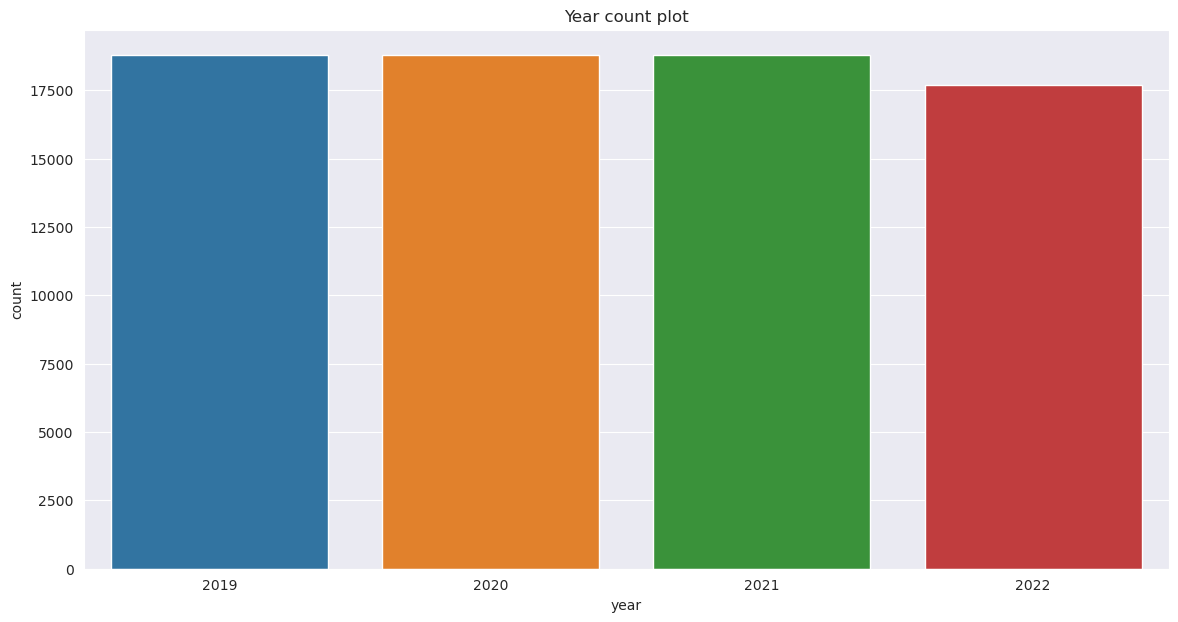

In [17]:
# Year countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'year', data = train)
plt.title('Year count plot')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the years
- Year 2022 has fewer number of observations

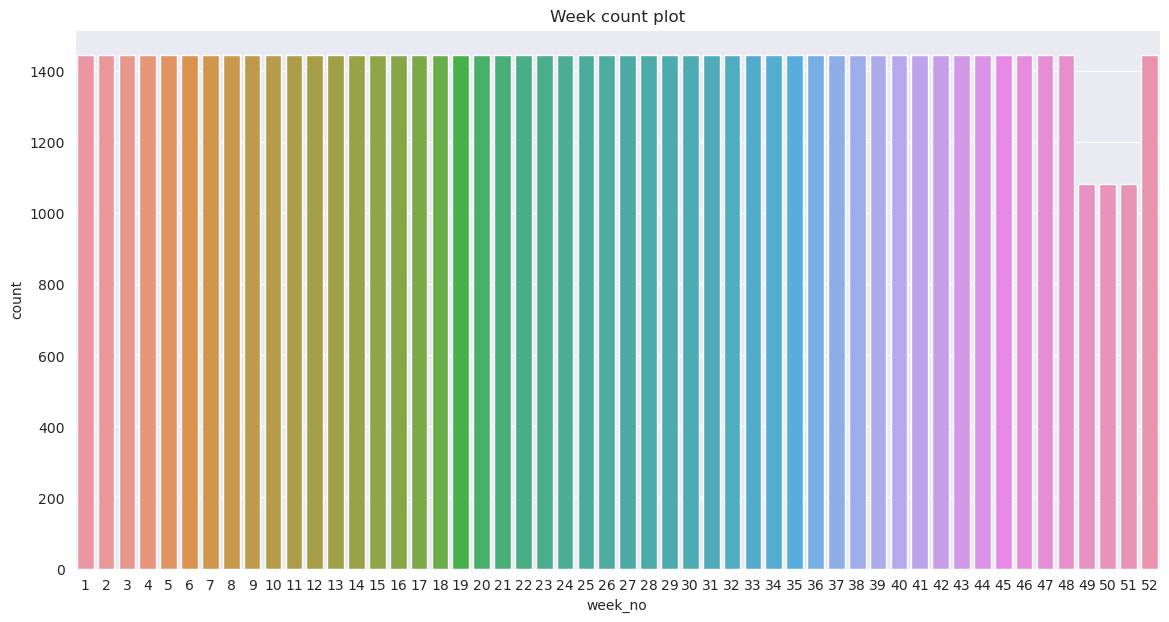

In [18]:
# Week countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'week_no', data = train)
plt.title('Week count plot')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the weeks
- Weeks 49, 50 and 51  have fewer number of observations when compared to the other weeks

In [19]:
train.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

- The year 2022 has only 49 weeks available in the data

## Add some Insights on emissions per month

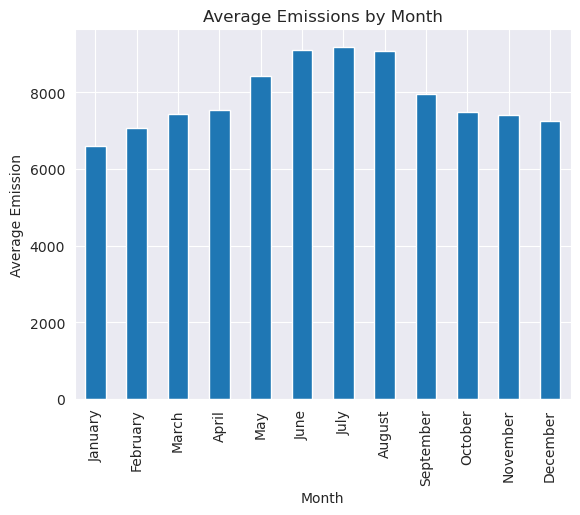

In [ ]:
# Create a new feature 'month' from 'week_no'
train['month'] = (train['week_no'] / 4.34524).astype(int)
test['month'] = (test['week_no'] / 4.34524).astype(int)

# Analyze the distribution of emissions by month
monthly_emissions = train.groupby('month')['emission'].mean()

# Define a mapping for the months
month_mapping = {0: 'January', 1: 'February', 2: 'March', 3: 'April', 4: 'May', 5: 'June', 6: 'July', 7: 'August', 8: 'September', 9: 'October', 10: 'November', 11: 'December'}

# Apply the mapping to the index of the monthly_emissions Series
monthly_emissions.index = monthly_emissions.index.map(month_mapping)

# Visualize the trend of emissions every month using a bar graph
monthly_emissions.plot(kind='bar')
plt.title('Average Emissions by Month')
plt.xlabel('Month')
plt.ylabel('Average Emission')
plt.show()

- The month with the highest average emission is July.
- The month with the lowest average emission is January.

In [ ]:
# Get the month with the highest average emission
max_emission_month = monthly_emissions.idxmax()
print(f'The month with the highest average emission is {max_emission_month}.')

# Get the month with the lowest average emission
min_emission_month = monthly_emissions.idxmin()
print(f'The month with the lowest average emission is {min_emission_month}.')

# Get the range of average emissions
emission_range = monthly_emissions.max() - monthly_emissions.min()
print(f'The range of average emissions is {emission_range}.')

The month with the highest average emission is July.
The month with the lowest average emission is January.
The range of average emissions is 2576.944362014875.


<a name="Correlations"></a>
## 8. Correlations - EDA

In [20]:
# Top 20 correlated features to the target
top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False)
top20_corrs

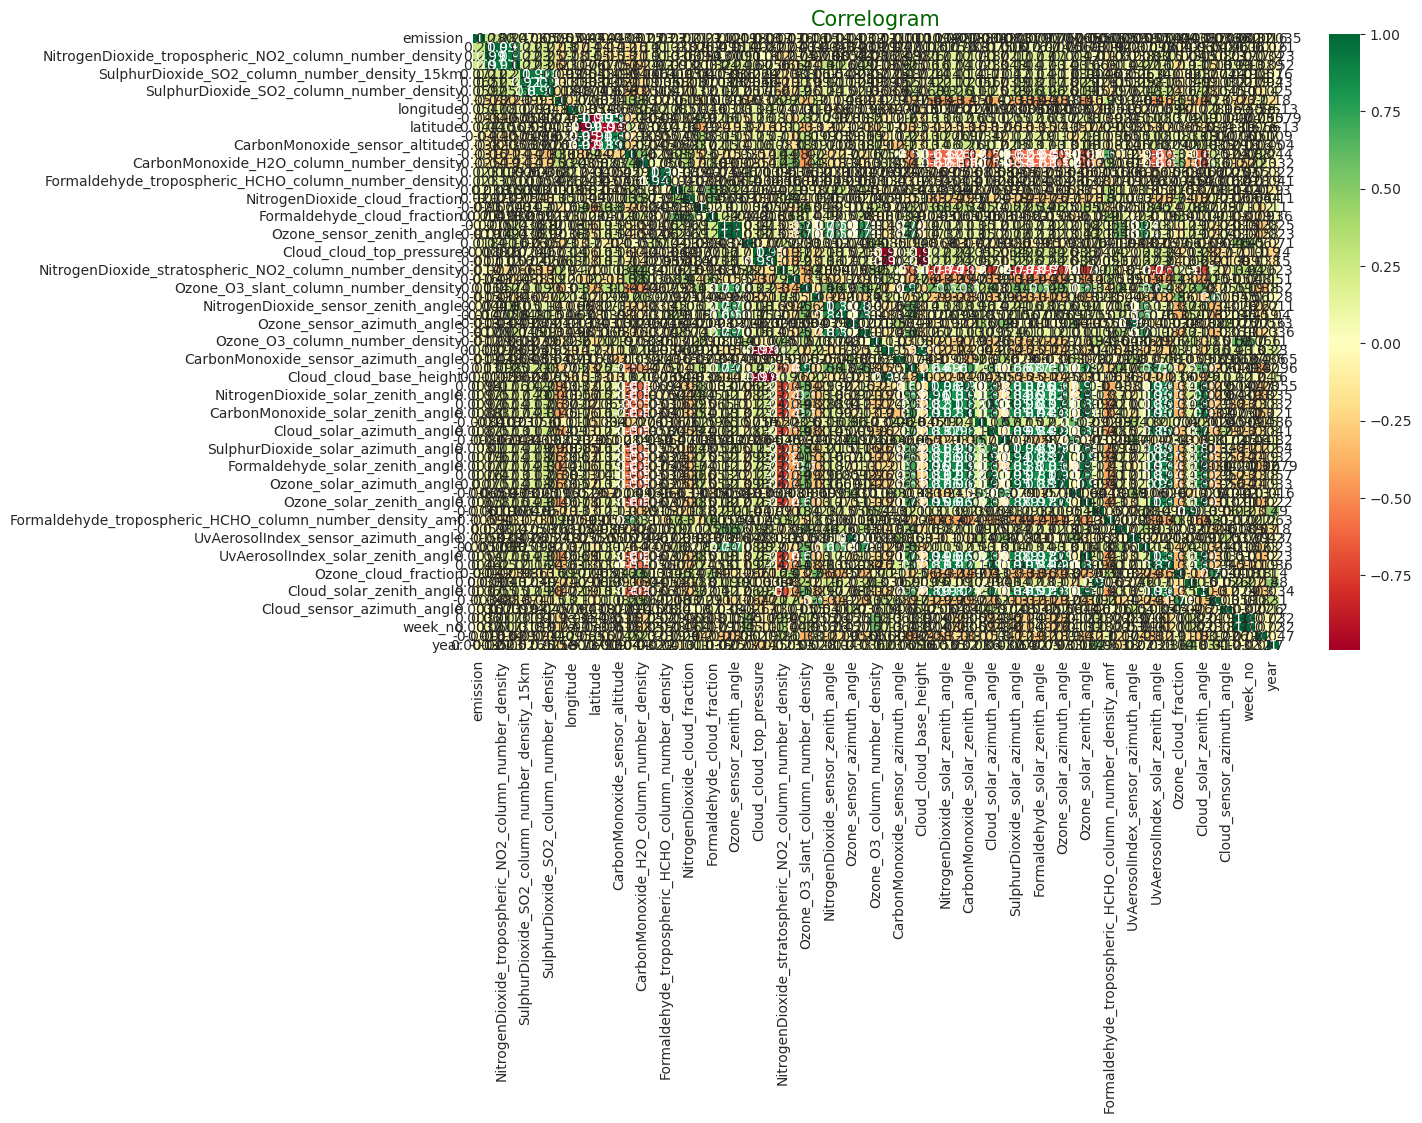

In [21]:
# Quantify correlations between features
corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

<a name="Timeseries"></a>
## 9. Timeseries visualization - EDA

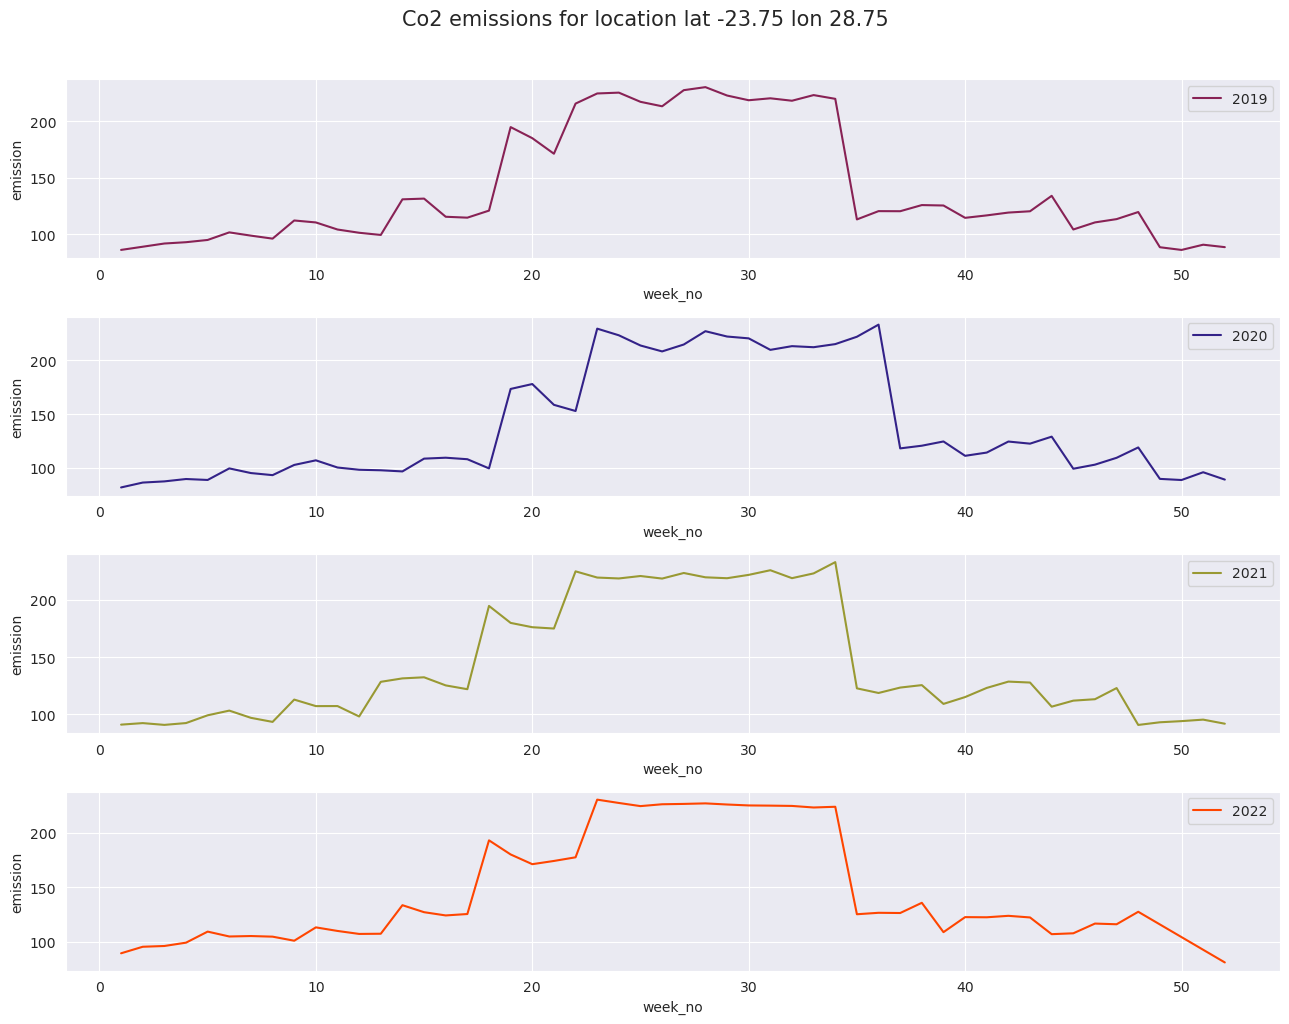

In [22]:
# Sample a unique location and visualize its emissions across the years
train.latitude, train.longitude = round(train.latitude, 2), round(train.longitude, 2)
sample_loc = train[(train.latitude == -23.73) & (train.longitude == 28.77)]

# Plot a line plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (13, 10))
fig.suptitle('Co2 emissions for location lat -23.75 lon 28.75', y=1.02, fontsize = 15)

for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc.year.unique(), ['#882255','#332288', '#999933' , 'orangered']):
  df = sample_loc[sample_loc.year == year]
  sns.lineplot(x=df.week_no,y= df.emission, ax = ax, label = year, color = color)
plt.legend()
plt.tight_layout()

<a name="Engineering"></a>
## 10. Feature engineering









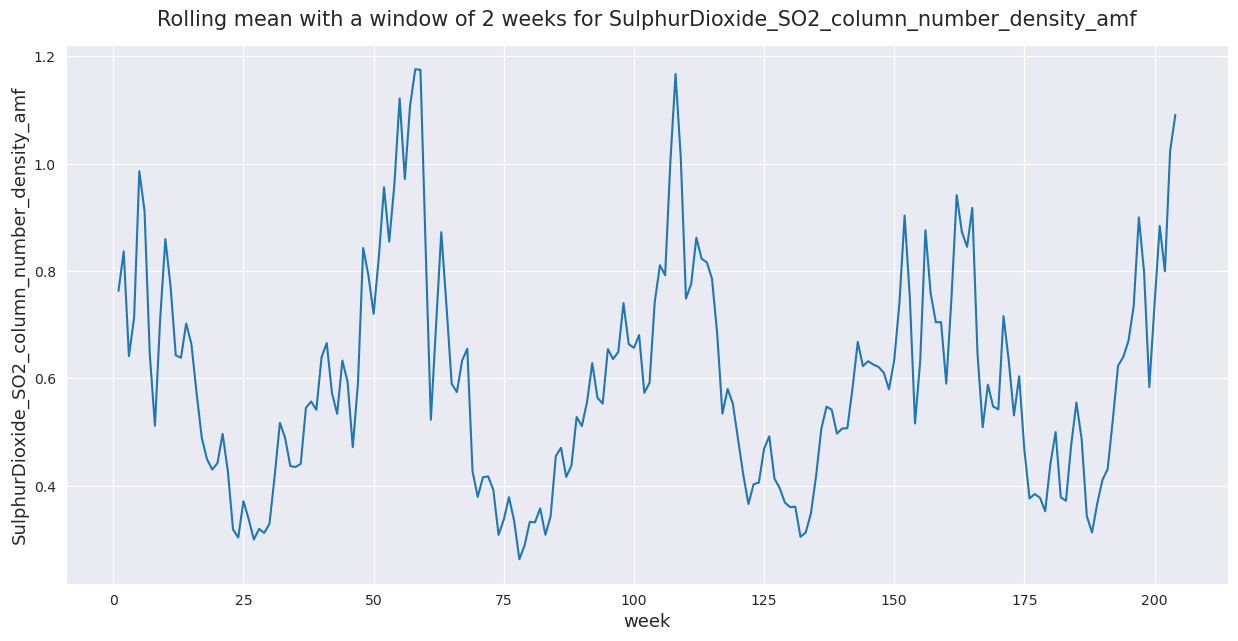

In [23]:
# Examples of feature engineering - Aggregations, cumulative differences, moving averages ...
# Lets explore the rolling mean
# First we create a unique location from lat lon
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train.latitude, train.longitude)]

# Filter based on one location
example_loc = train[train.location == '-23.73_28.77']

# Calculate rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

# Visualise rolling mean
plt.figure(figsize = (15, 7))
rolling_mean.plot()
plt.title('Rolling mean with a window of 2 weeks for SulphurDioxide_SO2_column_number_density_amf', y = 1.02, fontsize = 15)
plt.xlabel('week', y = 1.05, fontsize = 13)
plt.ylabel('SulphurDioxide_SO2_column_number_density_amf', x = 1.05, fontsize = 13)
plt.show()

 - There is a cyclic pattern from the above graph, which clearly shows that there is a pattern - This will be helpful to our model
 - With more research and domain knowledge generate useful features that can improve your model performance

 Other examples of feature engineering:
  - Creating cluster regions
  - Interactions between different pollutatnts - ratios, additions,subtractions...
  - Time series features

## Additional Sample Features

In [ ]:
# Create a new feature 'day_of_year' from 'week_no'
train['day_of_year'] = train['week_no'] * 7
test['day_of_year'] = test['week_no'] * 7

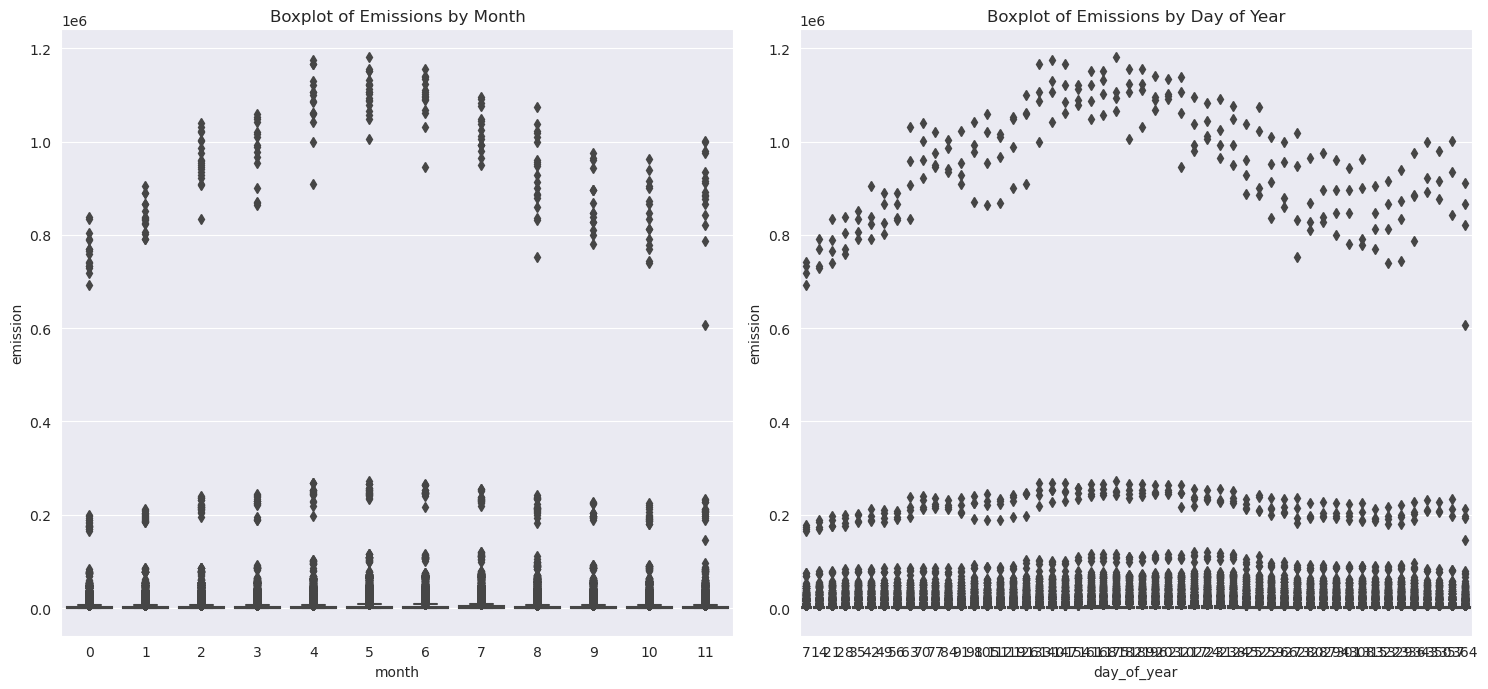

In [ ]:
# Visualize the impact of the new features
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
sns.boxplot(x='month', y='emission', data=train)
plt.title('Boxplot of Emissions by Month')
plt.subplot(1, 2, 2)
sns.boxplot(x='day_of_year', y='emission', data=train)
plt.title('Boxplot of Emissions by Day of Year')
plt.tight_layout()
plt.show()

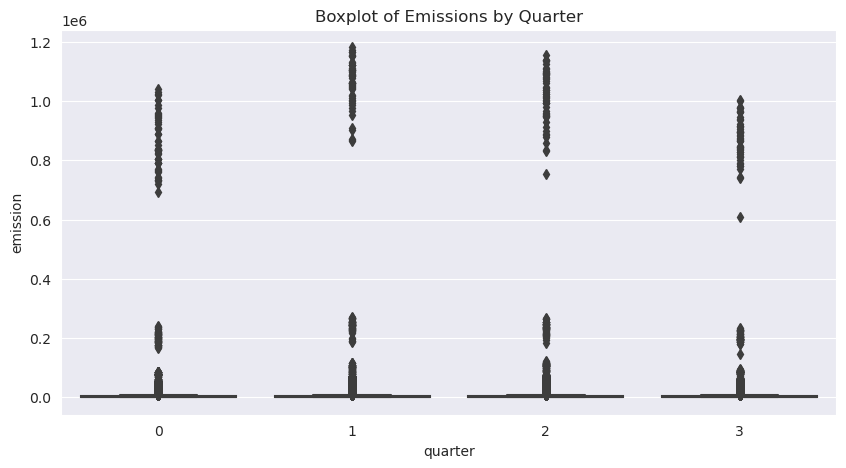

In [ ]:
# Create a new feature 'quarter' from 'month'
train['quarter'] = (train['month'] / 3).astype(int)
test['quarter'] = (test['month'] / 3).astype(int)
# Visualize the impact of the new 'quarter' feature
plt.figure(figsize=(10, 5))
sns.boxplot(x='quarter', y='emission', data=train)
plt.title('Boxplot of Emissions by Quarter')
plt.show()

In [24]:
# Generate the above feature - rolling mean for all locations for both the train and test

# Feature engineering train
train_roll_mean = train.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[train.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
train_roll_mean.drop(['level_1', 'emission', 'location'], axis = 1, inplace = True)
train_roll_mean.columns = [col + '_roll_mean' for col in train_roll_mean.columns]

# Feature engineering test
test.latitude, test.longitude = round(test.latitude, 2), round(test.longitude, 2)
test['location'] = [str(x) + '_' + str(y) for x, y in zip(test.latitude, test.longitude)]
test_roll_mean = test.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[test.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
test_roll_mean.drop(['level_1', 'location'], axis = 1, inplace = True)
test_roll_mean.columns =  [col + '_roll_mean' for col in test_roll_mean.columns]
test_roll_mean.head()

In [25]:
# Merge engineered features with train and test set

#Train
train_eng = train.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(train_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Test
test_eng = test.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(test_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Preview engineered test set
test_eng.head()

<a name="Modelling"></a>
## 11.  Modelling

In [26]:
# Selecting the independent variables and the target variable
# X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', # #'emission','month','quarter','day_of_year'], axis = 1).fillna(0)

X=train_eng.loc[:,['latitude','longitude','NitrogenDioxide_tropospheric_NO2_column_number_density','NitrogenDioxide_NO2_slant_column_number_density','SulphurDioxide_SO2_column_number_density_15km','SulphurDioxide_SO2_column_number_density','NitrogenDioxide_NO2_column_number_density']].fillna(0)

y = train_eng.emission
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)
# Instantiating the model
clf = RandomForestRegressor(random_state = SEED, n_jobs=-1)
clf.fit(X_train, y_train)
# Making predictions
y_pred = clf.predict(X_test)
# Measuring the accuracy of the model
print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}')

RMSE Score: 6126.795285086066


In [27]:
X_test.head()

In [28]:
# Analyse predictions
pred_errors = X_test.copy()
pred_errors['emission'] = y_test
pred_errors['prediction'] = y_pred
pred_errors['error'] = abs(pred_errors.prediction - pred_errors.emission)
#	'year',	'week_no',
pred_errors = pred_errors[['latitude',	'longitude', 'emission', 'prediction', 'error']]
pred_errors.sort_values(by = 'error', ascending = False, inplace = True)
pred_errors.head()

In [29]:
pred_errors.tail()

In [30]:
train.emission.describe()

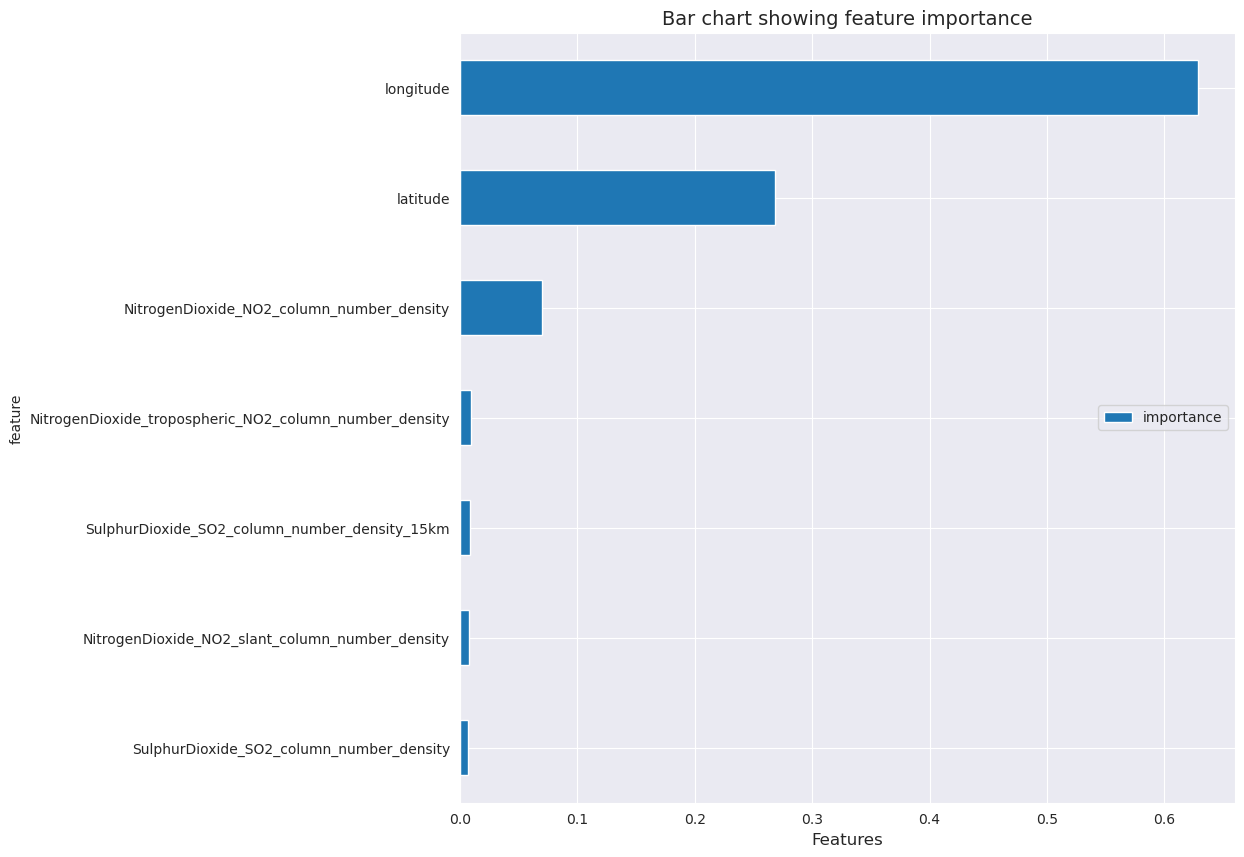

In [31]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

<a name="Predictions"></a>
## 12. Making predictions of the test set and creating a submission file

In [32]:
# Make prediction on the test set
# test_df = test_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location','month','quarter'], axis = 1).fillna(0)

test_df = test_eng.loc[:,['latitude','longitude','NitrogenDioxide_NO2_column_number_density','NitrogenDioxide_tropospheric_NO2_column_number_density','NitrogenDioxide_NO2_slant_column_number_density','SulphurDioxide_SO2_column_number_density_15km','SulphurDioxide_SO2_column_number_density']].fillna(0)
#test_df = test_eng.loc[:,['latitude','longitude','NitrogenDioxide_NO2_column_number_density','SulphurDioxide_SO2_column_number_density_15km','Cloud_surface_albedo','UvAerosolIndex_sensor_altitude']].fillna(0)
predictions = clf.predict(test_df)

# # Create a submission file
sub_file = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_eng.ID_LAT_LON_YEAR_WEEK, 'emission': predictions})
sub_file.head()

In [33]:
# Create file
sub_file.to_csv('Submission2.csv', index = False) # Download subfile and submit to zindi for scoring

## ALL THE BEST AND HAVE FUN &#x1F60E;